## MNISTで多クラス分類

In [88]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [89]:
# 1. データロード
from sklearn import datasets
dataset = datasets.load_digits()
images = dataset['images']
target = dataset['target']

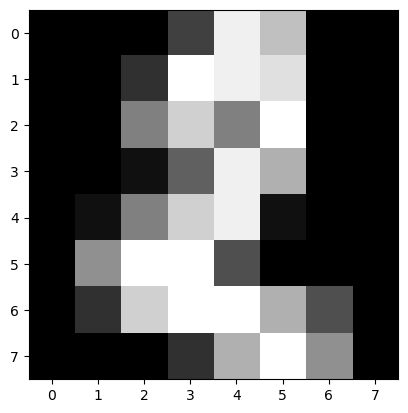

In [90]:
plt.imshow(images[2], cmap='gray')

In [91]:
target

array([0, 1, 2, ..., 8, 9, 8])

In [92]:
# 学習データと検証データに分割
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

In [93]:
# 2. 前処理

# 2-1. ラベルのonehotencoding
y_train = F.one_hot(torch.tensor(y_train), num_classes=10)
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 64)

y_val = F.one_hot(torch.tensor(y_val), num_classes=10)
X_val = torch.tensor(X_val, dtype=torch.float32).reshape(-1, 64)

# 2-2. 画像の標準化
X_train = (X_train - X_train.mean()) / X_train.std()
X_val = (X_val - X_train.mean()) / X_train.std()

In [94]:
learning_rate = 0.03
loss_log = []

In [95]:
# 3. パラメータの初期化
W = torch.rand((10, 64), requires_grad=True)   # 出力x入力
b = torch.rand((1, 10), requires_grad=True)   # 1x出力

In [96]:
# 4. softmaxとcross_entropy
def softmax(x):
    e_x = torch.exp(x - torch.max(x, dim=1, keepdim=True)[0])
    return e_x / (torch.sum(e_x, dim=1, keepdim=True) + 1e-10)

def cross_entropy(y_true, y_pred):
    return -torch.sum(y_true * torch.log(y_pred + 1e-10)) / y_true.shape[0]

In [97]:
# バッチサイズ
batch_size = 30
num_batches = np.ceil(len(y_train) / batch_size).astype(int)

# epoch
epochs = 30

In [98]:
# ログ
train_losses = []
val_losses = []
val_accuracies = []

In [99]:
# 5. for文で学習ループ作成
for epoch in range(epochs):

    shuffled_indcies = np.random.permutation(len(y_train))   # データのindexをシャッフル
    running_loss = 0

    for i in range(num_batches):

        # mini-batch作成
        start = i * batch_size
        end = start + batch_size
        batch_indices = shuffled_indcies[start:end]

        # 6. 入力データxおよび教師ラベルのYを作成
        y_true_ = y_train[batch_indices, :]
        X = X_train[batch_indices, :]

        #import pdb; pdb.set_trace()   # デバッカー（ここでコードを止めてくれる）

        # 7. z計算
        z = X @ W.T + b

        # 8. softmaxで予測計算
        y_pred = softmax(z)

        # 9. 損失計算
        loss = cross_entropy(y_true_, y_pred)
        loss_log.append(loss.item())
        running_loss += loss.item()

        # 10. 勾配計算
        loss.backward()

        # 11. パラメータ更新
        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate + b.grad
        
        # 12. 勾配初期化
        W.grad.zero_()
        b.grad.zero_()

    # validation
    with torch.no_grad():
        z_val = X_val @ W.T + b
        y_pred_val = softmax(z_val)

        val_loss = cross_entropy(y_val, y_pred_val)
        val_accuracy = torch.sum(torch.argmax(y_pred_val, dim=-1) == torch.argmax(y_val, dim=-1)) / y_val.shape[0]

    train_losses.append(running_loss/num_batches)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

    
    # 13. 損失ログ出力
    print(f'epoch: {epoch+1}: train_loss:{running_loss/num_batches}, val_loss:{val_loss.item()}, val_acuraccy:{val_accuracy.item()}')

epoch: 1: train_loss:2.835403169194857, val_loss:13.90495491027832, val_acuraccy:0.16388888657093048
epoch: 2: train_loss:1.461123698701461, val_loss:10.092293739318848, val_acuraccy:0.33888888359069824
epoch: 3: train_loss:0.9676776180664698, val_loss:8.2736177444458, val_acuraccy:0.4305555522441864
epoch: 4: train_loss:0.7445639154563347, val_loss:7.0497307777404785, val_acuraccy:0.4861111044883728
epoch: 5: train_loss:0.616110016281406, val_loss:6.093035697937012, val_acuraccy:0.5416666865348816
epoch: 6: train_loss:0.5304351871212324, val_loss:5.328108310699463, val_acuraccy:0.5805555582046509
epoch: 7: train_loss:0.4700807264695565, val_loss:4.863088607788086, val_acuraccy:0.605555534362793
epoch: 8: train_loss:0.4256394663825631, val_loss:4.336323261260986, val_acuraccy:0.644444465637207
epoch: 9: train_loss:0.3906311886385083, val_loss:4.083366394042969, val_acuraccy:0.6416666507720947
epoch: 10: train_loss:0.3646944745754202, val_loss:3.5261216163635254, val_acuraccy:0.68611109

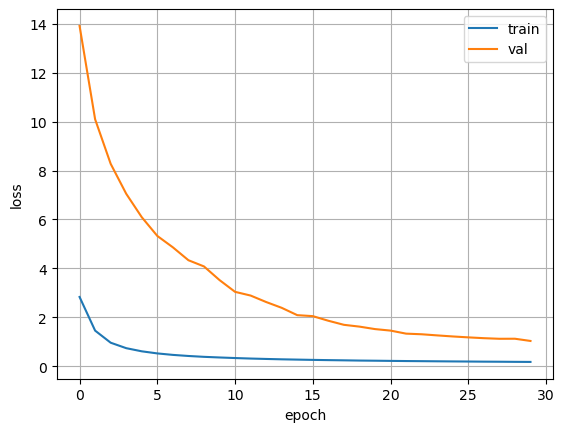

In [106]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()